# AutoML Tutorials mit Autogluon

## Get started in Colab<a class="anchor" id="1"></a>
1. Klicke auf [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github//IIS-KI-Tutorials/KI-Tutorials/blob/main/AutoML_Tutorials.ipynb) um dieses Notebook als Session in Colab zu starten.
<br/>------In Colab------------------------------------------------------------------------

2. Klicke auf Laufzeit > Laufzeittyp ändern > T4 GPU > Speichern
3. Führe die nächste Zelle aus um die benötigten Daten in die Session zu laden und um benötigte Requirements zu installieren. Diese benötigt ca 6-7 min.
4. Klicke anschließend im Output der Zelle auf "**Restart Session**".

In [ ]:
!wget -q -P ./data https://raw.githubusercontent.com/IIS-KI-Tutorials/KI-Tutorials/main/data/Bike_Sharing_Webinar.csv
!wget -q -P ./data https://raw.githubusercontent.com/IIS-KI-Tutorials/KI-Tutorials/main/data/CWRU.csv
!wget -q -P ./data https://github.com/IIS-KI-Tutorials/KI-Tutorials/raw/main/data/Metallgussteile.zip
!unzip -q ./data/Metallgussteile.zip -d ./data
!rm ./data/Metallgussteile.zip
!pip install autogluon==0.8

-------------AB HIER BEGINNEN DIE EIGENTLICHEN TUTORIALS--------------------


## Inhaltsverzeichnis
1. **Fahrrad Sharing-Prognose - Regression mit tabellarischen Daten**<br/><br/>
Dieses Kapitel dient als praxisnahes Beispiel für die Anwendung von AutoML bei der Vorhersage der Fahrradverleihnachfrage anhand tabellarischer Daten. Wir werden verschiedene Einflussfaktoren wie den Wochentag und Wetterbedingungen nutzen, um präzise Prognosen zu erstellen. <br/><br/><br/>
2. **Fehlerdiagnose bei Kugellagern - Zeitreihenklassifikation**<br/><br/>
Hier zeigen wir, wie AutoML für die Klassifikation von Zeitreihendaten genutzt werden kann, insbesondere für die Identifikation verschiedener Fehlerarten in Kugellagern. Durch die Anwendung von zeitlichen Mustern wird eine zuverlässige Fehlerklassifikation erreicht. <br/><br/><br/>
3. **Qualitätskontrolle von Metallgussteilen - Bildklassifikation**<br/><br/>
Dieses Kapitel veranschaulicht die Anwendung von AutoML für die Entwicklung eines Vorhersagemodells anhand von Bilddaten. Unser Ziel ist es, ein automatisches Qualitätskontrollsystem für Metallgussteile zu schaffen, indem wir Bildinformationen effektiv nutzen.

## 1. Fahrrad Sharing-Prognose - Regression mit tabellarischen Daten <a class="anchor" id="2"></a>

Dieses Notebook ist ein einfaches Beispiel dafür, wie man ein Vorhersagemodell mittels AutoML anhand von tabellarischen Daten trainiert.
Ziel ist es, die Nachfrage nach Leihfahrrädern für einen Tag anhand verschiedener Informationen wie Wochentag, Wetterbedingungen etc. vorherzusagen.
Die Zielvariable ist also eine kontinuierliche Größe, weshalb wir in diesem Fall von einem Regressionsproblem sprechen.

### Inhaltsverzeichnis
1. [Importiere AutoML Framework - AutoGluon](#2_1)<br/>
2. [Laden der Daten](#2_2)<br/>
3. [Merkmal- und Labelauswahl](#2_3)<br/>
4. [Unterteile die Daten in Trainings- und Testdaten](#2_4)<br/>
5. [Modell Training](#2_5)<br/>
6. [Modell Test](#2_6)<br/>
7. [Model Interpretation](#2_7)<br/>
8. [Modell exportieren/speichern](#2_8)<br/>
9. [Modell laden](#2_9)<br/>
10. [Vorhersagen für neue Daten](#2_10)<br/>

### 1 Importiere AutoML Framework - AutoGluon <a class="anchor" id="2_1"></a>
In diesem Beispiel verwenden wir das AutoML-Framework AutoGluon. Da es sich bei dem Datensatz um tabellarische Daten handelt, benötigen wir für die Bearbeitung des vorliegenden Problems  lediglich die Klassen `TabularDataset` und `TabularPredictor`, welche wir hier importieren. Darüber hinaus importieren wir ebenso die Bibliothek `matplotlib` für spätere Visualisierungen.

In [48]:
from autogluon.tabular import TabularDataset, TabularPredictor
import matplotlib.pyplot as plt # Bibliothek für Visualisierungen

### 2 Laden der Daten <a class="anchor" id="2_2"></a>
Als nächstes laden wir die Daten mit Hilfe der `TabularDataset` Klasse und speichern sie in der Variable `data`. Mittels der `head()` Methode können wir uns die ersten 5 Instanzen des Datensatzes anzeigen lassen. Dadurch erhalten wir einen Einblick, wie unsere Daten ausschauen. Allgemeine Informationen zum Datensatz sind unter foldendem Link zu finden: [https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset)

In [49]:
data = TabularDataset('./data/Bike_Sharing_Webinar.csv')
data.head()

Loaded data from: ./data/Bike_Sharing_Webinar.csv | Columns = 15 / 15 | Rows = 731 -> 731


,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01,winter,0,1,0,saturday,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2011-01-02,winter,0,1,0,sunday,0,2,NaN,NaN,NaN,NaN,131,670,801
2,2011-01-03,winter,0,1,0,monday,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,2011-01-04,winter,0,1,0,tuesday,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,2011-01-05,winter,0,1,0,wednesday,1,1,NaN,NaN,NaN,NaN,82,1518,1600


Im Folgenden sehen wir die Auflistung aller Merkmale und Label.
Es sei zu beachten, dass es sowohl kategorische (season und weekday) als auch numerische Merkmale (yr, mnth, ...) gibt.
Teilweise gibt es auch fehlende Messwerte (s. NaN).
Außerdem sei anzumerken, dass es insgesamt drei Label gibt.

Merkmale:
- **dteday**: Datum
- **season**: Jahreszeit
- **yr**: Jahr
    - 0: 2011
    - 1: 2012
- **mnth**: Monat (1 bis 12)
- **holiday**: Feiertag?
    - nein: 0
    - ja: 1
- **weekday**: Wochentag
- **workingday**:
    - 1: wenn weder Wochenende noch Feiertag
    - 0: sonst
- **weathersit**:
    - 1: klar, leicht/teilweise bewölkt
    - 2: bewölkt, Nebel
    - 3: leichter Regen/Schnee, Gewitter
    - 4: starker Regen/Schnee, Sturm
- **temp**: Temperatur (normalisiert)
- **atemp**: gefühlte Temperatur (normalisiert)
- **hum**: Luftfeuchtigkeit
- **windspeed**: Windgeschwindigkeit (normalisiert)

Label:
- **casual**: Anzahl der nicht-registrierten Nutzer
- **registered**: Anzahl der registrierten Nutzer
- **cnt**: Gesamtzahl der Nutzern

### 3 Merkmal- und Labelauswahl <a class="anchor" id="2_3"></a>
Damit das AutoML Framework später ein Modell trainieren kann, müssen wir zunächst angeben, welche der Spalten Merkmale repräsentieren und welche die Label. Für den Moment wollen wir `casual` als Label wählen, d.h. wir wollen also die Anzahl der nicht-registrierten Nutzer pro Tag vorhersagen. Bei den Merkmalen lassen wir das Datum weg, da wir schon über die Spalten 'yr', 'mnth' sowie 'weekday' verfügen.

In [50]:
features = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
label = 'casual'

Um ein besseres Verständnis über die Daten zu erlangen, wollen wir nun das ausgewählte Label über die Zeit plotten. Hier wird z.B. deutlich, dass es einen merklichen saisonalen Effekt gibt. Die Nachfrage nach Fahrrädern ist also im Sommer höher als im Winter. Auch gibt es deutliche Schwankungen innerhalb einer Woche. So zeigt sich, dass die Anzahl der nicht-registrierten Nutzer vor allem am Wochende hoch ist, während sie unter der Wocher deutlich geringer ausfällt.

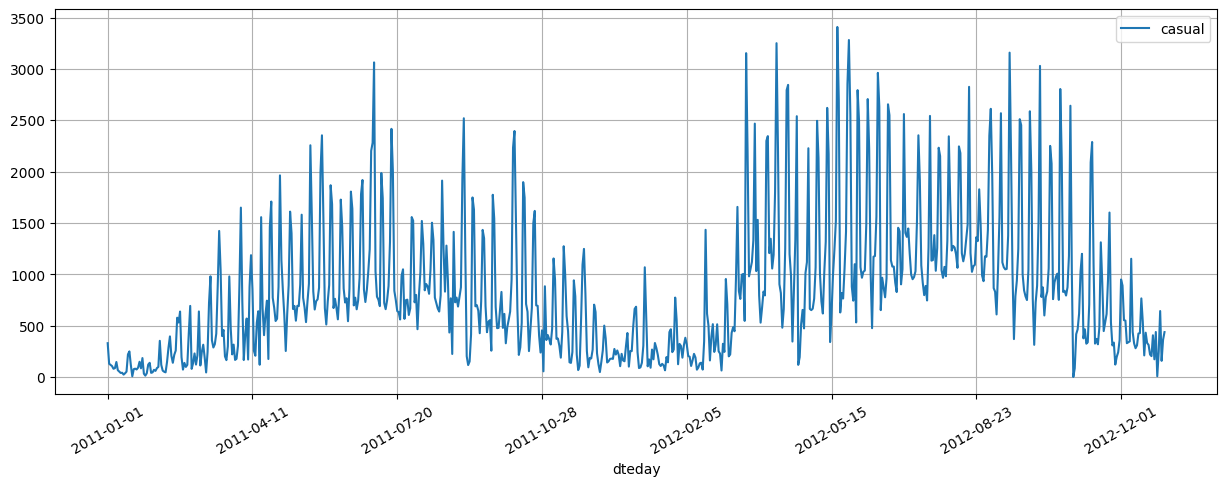

In [51]:
fig, ax = plt.subplots(figsize=(15, 5))
data.plot('dteday', label, rot=30, ax=ax)
plt.grid()

### 4 Unterteile die Daten in Trainings- und Testdaten <a class="anchor" id="2_4"></a>
Nun unterteilen wir unseren Datensatz in Trainings- und Testset.

Die ersten 80% der Daten werden als Trainingsdaten und die letzten 20% als Testdaten ausgewählt. Das AutoML Framework wird also lediglich die Trainingsdaten für das Training und Validieren von Modellen benutzen. Mit den Testdaten wird das finale Modell abschließend getestet, um seine Genauigkeit angeben zu können.

In [52]:
train_size = round(0.8 * len(data))

all_columns =  features + [label]

data_train = data.loc[:train_size, all_columns]
data_test = data.loc[train_size:, all_columns]

### 5 Modell Training <a class="anchor" id="2_5"></a>
In der folgenden Zelle findet das Modell Training durch das AutoML Framework statt.

In der ersten Zeile erzeugen wir zuerst eine Instanz der Klasse `TabularPredictor` und speichern diese in der Variablen `predictor`.
Hier müssen wir lediglich den Namen der Zielvariable angeben (Diese haben wir vor einigen Zellen bereits in der Variable `label` gespeichert).
Optional kann man auch den Pfad angeben, in dem sämtliche Modelle gespeichert werden sollen (hier: "AutogluonModels/Fahrrad_Sharing").
Gibt man keinen Pfad an, so wird automatisch ein Ordner "AutogluonModels/ag-\<Datum>_\<Uhrzeit>"  erstellt, in dem die Modelle gespeichert werden.

In der zweiten Zeile rufen wir dann die `fit()` Methode auf, welche das Modell Training startet.
Diese Methode benötigt unsere vorher definierten Trainingsdaten als Argument.

Das AutoML Framework trainiert und validiert nun mit Hilfe dieser Daten viele verschiedene Modelle und gibt automatisch das beste Ensemble-Modell zurück.
Dieses speichern wir in der `predictor` Variable.

Es sei zu beachten, dass das Framework automatisch erkennt, dass es sich um ein Regressionsproblem handelt.
Auch erkennt es die verschiedenen Datentypen der vorhandenen Merkmale und kodiert etwa die kategorischen Label automatisch in numerische um.

In [53]:
predictor = TabularPredictor(label=label, path='./results/Fahrrad_Sharing')
predictor.fit(data_train)
print('Done!')

Beginning AutoGluon training ...
AutoGluon will save models to "./results/Fahrrad_Sharing\"
AutoGluon Version:  0.8.0
Python Version:     3.10.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Disk Space Avail:   1646.84 GB / 2027.27 GB (81.2%)
Train Data Rows:    586
Train Data Columns: 11
Label Column: casual
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (3410, 9, 811.36689, 676.6872)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    118062.3 MB
	Train Data (Original)  Memory Usage: 0.12 MB (0.0% of available memory)


Done!


Mit der `fit_summary()` Methode können wir uns eine Zusammenfassung und Übersicht der trainierten Modelle anzeigen lassen. Die zweite Spalte zeigt hier den jeweiligen "score_val", sprich den RMSE (Wurzel des mittleren quadratischen Fehlers) auf den Validierungsdaten. Nach diesem Wert sind auch die Modelle absteigend sortiert. Das gewichtete Ensemble hat also die besten Ergebnisse erzielt.

Es wird darüber hinaus ein Diagramm erstellt, welches unter dem Pfad "AutogluonModels/Fahrrad_Sharing/SummaryOfModels.html" zu finden ist.

In [54]:
summary = predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model   score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2 -213.404834       0.023441  19.091666                0.000000           0.195160            2       True         12
1            LightGBMXT -218.646536       0.004004   1.571198                0.004004           1.571198            1       True          3
2              CatBoost -223.832761       0.003017   9.910059                0.003017           9.910059            1       True          6
3              LightGBM -234.448532       0.004420   1.674574                0.004420           1.674574            1       True          4
4               XGBoost -243.646787       0.005999   1.326575                0.005999           1.326575            1       True          9
5         ExtraTreesMSE -244.414103       0.028230   0.298318                0.028230           0.

c:\Users\kasper\AppData\Local\miniconda3\envs\ki-tutorials\lib\site-packages\autogluon\core\utils\plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


### 6 Modell Test <a class="anchor" id="2_6"></a>

Zur finalen Bewertung unserer Modelle führen wir eine Evaluierung auf den zuvor separat gehaltenen Testdaten durch. Diese Testdaten wurden im Vorfeld von den Trainingsdaten abgesondert, wodurch sie keinen Einfluss auf das Training hatten und bisher unbeachtet blieben.

In [55]:
predictor.leaderboard(data_test, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-266.674477,-213.404834,0.054183,0.023441,19.091666,0.003966,0.000000,0.195160,2,True,12
1,CatBoost,-277.101407,-223.832761,0.006001,0.003017,9.910059,0.006001,0.003017,9.910059,1,True,6
2,LightGBMXT,-279.669992,-218.646536,0.011945,0.004004,1.571198,0.011945,0.004004,1.571198,1,True,3
3,NeuralNetTorch,-286.466377,-282.855642,0.008047,0.006001,4.414100,0.008047,0.006001,4.414100,1,True,10
4,LightGBM,-295.540703,-234.448532,0.004998,0.004420,1.674574,0.004998,0.004420,1.674574,1,True,4
5,RandomForestMSE,-311.094220,-250.061147,0.108866,0.027915,0.306754,0.108866,0.027915,0.306754,1,True,5
6,ExtraTreesMSE,-311.214627,-244.414103,0.053835,0.028230,0.298318,0.053835,0.028230,0.298318,1,True,7
7,LightGBMLarge,-314.317332,-256.675190,0.013064,0.004001,5.951729,0.013064,0.004001,5.951729,1,True,11
8,XGBoost,-327.450622,-243.646787,0.019227,0.005999,1.326575,0.019227,0.005999,1.326575,1,True,9
9,NeuralNetFastAI,-377.800780,-309.892014,0.010000,0.009761,0.764456,0.010000,0.009761,0.764456,1,True,8


Der `score_test` ist entsprechend hier der negative RMSE. Je größer die Zahl desto besser. auch interessant ist das `pred_time_test` uns die Zeit angibt die eine einzelne Inferenz benötigt, dies könnte je nach Finalem Usecase eine Rolle spielen ob man sich vieleicht nicht doch für ein geringfügig schlechteres Modell, das aber deutlich schneller ist entscheidet. In diesem Fall würde das jedoch vermutlich weniger Sinn machen. 

Die Visualisierung der Vorhersagen im Vergleich zu den tatsächlichen Daten ist eine weitere Möglichkeit, die Leistung unseres Modells auf den Testdaten zu analysieren. Der folgende Plot zeigt die zeitliche Entwicklung sowohl der realen als auch der vom Modell prognostizierten Nachfrage.

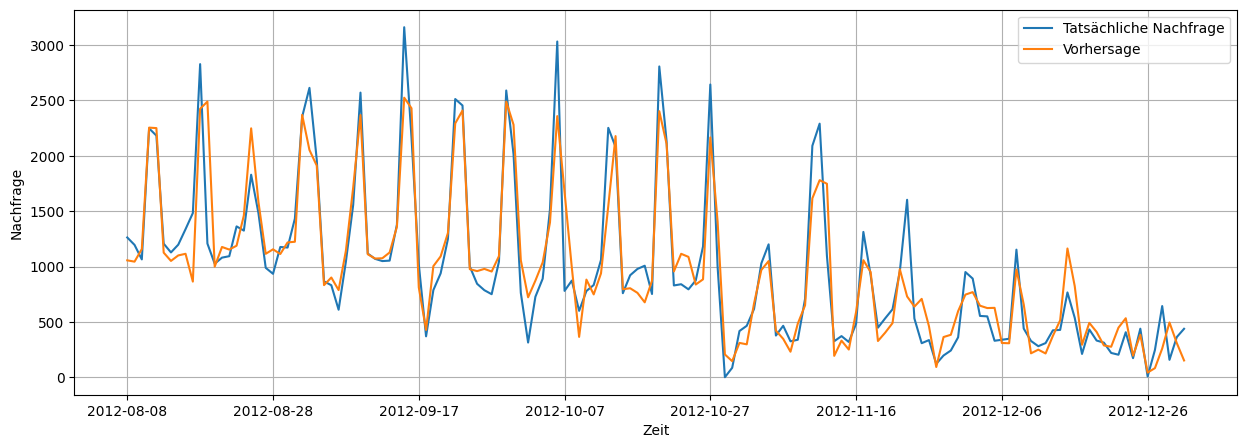

In [56]:
data_test[f'{label}_prediction'] = predictor.predict(data_test.drop(columns=[label]))
data_test['dteday'] = data.loc[train_size:, 'dteday']

fig, ax = plt.subplots(figsize=(15, 5))
data_test.plot(x="dteday", y=[f"{label}", f"{label}_prediction"], xlabel="Zeit", ylabel="Nachfrage", style='-', ax=ax)
plt.grid()
ax.legend(["Tatsächliche Nachfrage", "Vorhersage"]);

### 7 Model Interpretation <a class="anchor" id="2_7"></a>

Die retrospektive Beurteilung der Wichtigkeit unabhängiger Variablen ist eine weitere Möglichkeit, um zu verstehen, welche Faktoren tatsächlich für mein Problem relevant sind. In der nachfolgenden Zelle wird die sogenannte Merkmalswichtigkeit (englisch: feature importance) berechnet und aufgeführt. Ein höherer Wert der Wichtigkeit (importance) deutet darauf hin, dass das entsprechende Merkmal einen stärkeren Einfluss auf die Vorhersage hat. Diese Analyse kann äußerst aufschlussreich sein und dazu beitragen, ein besseres Verständnis der Daten zu erlangen.

In [57]:
predictor.feature_importance(data_test, silent=True)

These features in provided data are not utilized by the predictor and will be ignored: ['casual_prediction', 'dteday']


,importance,stddev,p_value,n,p99_high,p99_low
workingday,401.317859,39.024727,0.000011,5,481.670312,320.965406
atemp,165.547284,11.340043,0.000003,5,188.896589,142.197978
temp,119.569249,17.844824,0.000058,5,156.311989,82.826509
hum,55.132205,11.510934,0.000215,5,78.833377,31.431033
windspeed,50.118695,12.054596,0.000372,5,74.939275,25.298115
weekday,46.804526,2.864439,0.000002,5,52.702445,40.906607
weathersit,21.695221,5.849417,0.000577,5,33.739251,9.651191
mnth,13.258778,3.369614,0.000460,5,20.196860,6.320695
season,4.761438,2.565595,0.007131,5,10.044033,-0.521158
holiday,0.748310,0.374568,0.005549,5,1.519550,-0.022931


### 8 Modell exportieren/speichern <a class="anchor" id="2_8"></a>
Um das trainierte Modell später wieder laden und benutzen zu können, muss es gespeichert werden. Dies geschieht schon automatisch beim Modell Training. Bei Bedarf kann man jedoch auch im Nachhinhein das Modell mittels der `save()` Methode speichern.

In [59]:
predictor.save()

TabularPredictor saved. To load, use: predictor = TabularPredictor.load("./results/Fahrrad_Sharing\")


### 9 Modell laden <a class="anchor" id="2_9"></a>
Um ein gespeichertes Modell zu laden, ruft man ganz einfach die `load()` Methode auf.

In [60]:
predictor = TabularPredictor.load(path="./results/Fahrrad_Sharing")

### 10 Vorhersagen für neue Daten <a class="anchor" id="2_10"></a>
Das geladene Modell kann nun genutzt werden, um Vorhersagen auf zukünftigen, komplett unbekannten Daten zu machen. Da wir über solche nicht verfügen, laden wir hier eine zufällige Instanz aus dem uns vorliegenden Datensatz und machen dafür eine Vorhersage mit unserem geladenen Modell.

In [61]:
test_day = data.sample() # eine zufällige Instanz wird aus dem Datensatz gezogen
test_day

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
628,2012-09-20,summer,1,9,0,thursday,1,1,0.546667,0.532192,0.618333,0.118167,939,6781,7720


In [62]:
prediction = predictor.predict(test_day)
print(f'Vorhergesagte Nachfrage ({label}): {round(prediction.values[0])} Fahrräder')

Vorhergesagte Nachfrage (casual): 1092 Fahrräder


## 2. Fehlerdiagnose bei Kugellagern - Zeitreihenklassifikation<a class="anchor" id="3"></a>

In diesem Tutorial wird exemplarisch gezeigt, wie mithilfe von AutoML die Klassifikation von Zeitreihendaten durchgeführt werden kann. Das Ziel besteht darin, unterschiedliche Fehlertypen zu klassifizieren, die bei einem Kugellager auftreten können.

### Inhaltsverzeichnis
1. [Imports](#3_1)<br/>
2. [Laden der Daten](#3_2)<br/>
3. [Fenstern der Daten und Berechnen von Merkmalen](#3_3)<br/>
4. [Unterteile die Daten in Trainings- und Testdaten](#3_4)<br/>
5. [Modell Training](#3_5)<br/>
6. [Modell Test](#3_6)<br/>
7. [Modell Interpretation](#3_7)<br/>
8. [Modell exportieren/speichern](#3_8)<br/>
9. [Modell laden](#3_9)<br/>
10. [Vorhersagen für neue Daten](#3_10)<br/>

### 1 Imports <a class="anchor" id="3_1"></a>
Für das AutoML-Tool verwenden wir das Framework Autogluon, insbesondere `autogluon.tabular`. Um Zeitreihendaten in klassische tabellarische Daten umzuwandeln, benötigen wir in diesem Beispiel weitere Imports wie die Bibliotheken `numpy`, `pandas` und `sklearn`. Darüber hinaus nutzen wir `matplotlib.pyplot` für Visualisierungen. Für die spätere Evaluation importieren wir einige Funktionen aus den Bibliotheken `mlxtend` und `sklearn`.

In [63]:
# --- 3rd party ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from autogluon.tabular import TabularPredictor
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

Eine Funtion implementieren wir zudem noch selber, `get_windows`. Diese Funktion erhält eine Zeitreihe als Numpy-Array und gibt eine gefensterter Version der Zeitreihe zurück.

In [64]:
def get_windows(arr: np.ndarray, window_size: int, step_size: int) -> np.ndarray:
    """
    Window a 1D-array into windows of given size and with given step size.

    Parameters
    ----------
    arr : np.ndarray
        1D input array.
    window_size : int
        Window size in number of samples.
    step_size : int
        Step size in number of samples

    Returns
    -------
    output_array: np.ndarray
        2D output array of shape (n_windows, window_size)

    Examples
    --------
    >>> a = np.arange(6)
    >>> a
    array([0, 1, 2, 3, 4, 5])
    >>> get_windows(a, window_size=3, step_size=1)
    array([[0, 1, 2],
           [1, 2, 3],
           [2, 3, 4],
           [3, 4, 5]])
    """
    assert arr.ndim == 1

    n_rows = ((arr.size - window_size) // step_size) + 1
    n = arr.strides[0]

    return np.lib.stride_tricks.as_strided(arr, shape=(n_rows, window_size), strides=(step_size*n, n))

### 2 Laden der Daten <a class="anchor" id="3_2"></a>

Bearing Data Center vom CWRU

Original-Datensatz: [https://engineering.case.edu/bearingdatacenter/download-data-file](https://engineering.case.edu/bearingdatacenter/download-data-file)

![](./assets/CWRU_ilustration.png)

Diese Motorlagerexperimente wurden initiiert, um die Leistung von IQ PreAlert, einem bei Rockwell entwickelten Motorlager-Zustandsbewertungssystem, zu charakterisieren. Experimente wurden unter Verwendung eines 2-PS-Reliance-Elektromotors durchgeführt, und Beschleunigungsdaten wurden an Antriebs- und Lüftungsseite der Motorlager gemessen. Diese Motorlager wurden durch Elektroentladungsbearbeitung (EDM) mit Fehlern übersät. Fehler im Bereich von 0,007 Zoll Durchmesser bis 0,040 Zoll Durchmesser wurden separat an der inneren Laufbahn, dem Walzkörper (d. h. der Kugel) und der äußeren Laufbahn eingeführt. Fehlerhafte Lager wurden wieder in den Testmotor eingebaut und Vibrationsdaten mit einer Frequenz von 12 kHz aufgezeichnet.

Die Sensoren sind:
* Antriebsseite: acc0
* Lüftungsseite: acc1

Die Recording IDs sind wie folgt aufgebaut:
* Der erste Wert gibt den Ort des Fehlers an:
    * none: Kein Fehler
    * OR: Outer Race (Außenbahn)
    * IR: Inner Race (Innenbahn)
    * BA: Ball (Kugel)
* Der Zahlenwert definiert die Schwere des Fehlers (bzw. den Durchmesser):
    * 00: Kein Fehler
    * 07: 0.007''
    * 14: 0.014''
    * 21: 0.021''

Wir laden die Daten als sog. DataFrame und speichern sie in der Variablen `data`.

Der Datensatz beinhaltet mehr als 1,5 Mio. Messpunkte (Instanzen).
Neben der Zeitspalte sehen wir die beiden Beschleunigungssensoren ("acc0" und "acc1") sowie die Spalte "recording_id".
Es gibt insgesamt 10 verschiedene recording_ids, von denen jede eine einzelne Messung repräsentiert.
Da pro Messung immer nur ein bestimmter Fehler vorhanden war, entspricht dies im Grunde der Label-Spalte.

In [65]:
data = pd.read_csv("./data/CWRU.csv")
data

,time,acc0,acc1,recording_id
0,0.000000,0.105420,0.204633,BA_14
1,0.000083,-0.107370,0.248395,BA_14
2,0.000167,-0.163410,0.042324,BA_14
3,0.000250,0.118903,-0.015615,BA_14
4,0.000333,0.184039,-0.058555,BA_14
...,...,...,...,...
1584628,10.165583,-0.156344,0.063691,IR_21
1584629,10.165667,1.099280,-0.059376,IR_21
1584630,10.165750,0.231876,-0.080949,IR_21
1584631,10.165833,-1.241410,0.110945,IR_21


Als Label der verschiedenen Zeitreihen wird hier die `recording_id` verwendet.

In [66]:
unique_recording_ids = sorted(data['recording_id'].unique())
print(f'Liste der vorkommenden recording_ids bzw. Labels:\n\n{", ".join(unique_recording_ids)}')

Liste der vorkommenden recording_ids bzw. Labels:

BA_07, BA_14, BA_21, IR_07, IR_14, IR_21, OR_07, OR_14, OR_21, none_00


Um eine bessere Intuition über unsere Daten zu bekommen plotten wir uns zwei der Aufnahmen. Da wir diese anschließend gleich fenstern werden, plotten wir zudem noch vertikale linien für die Fenstergrenzen.

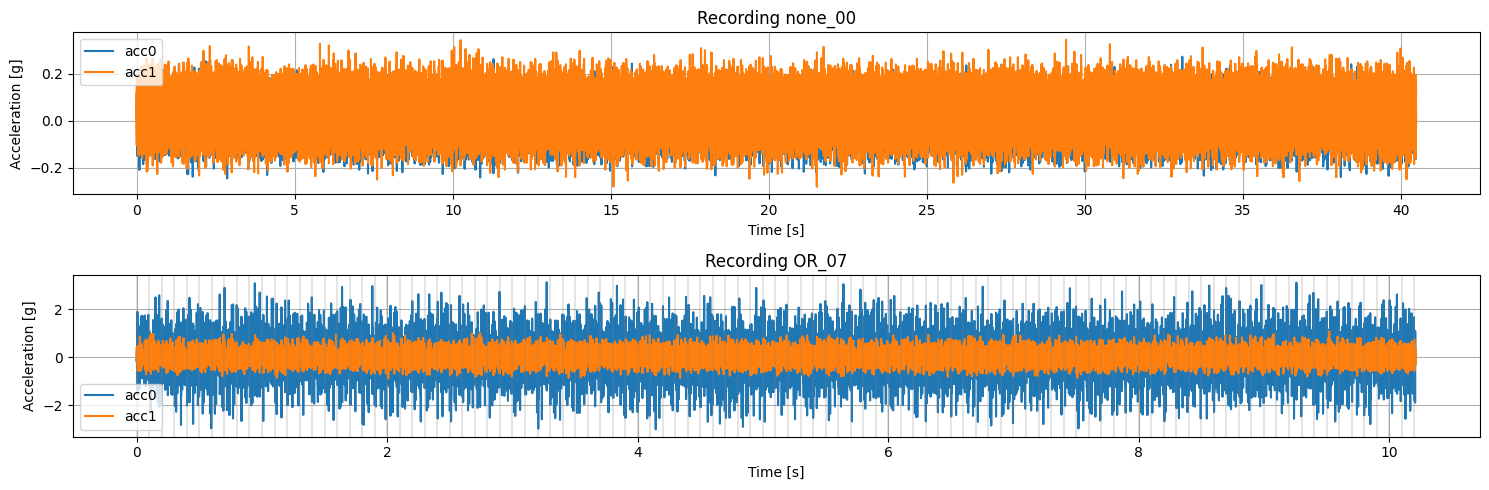

In [74]:
window_length = 0.1  # window size in seconds

fig, axes = plt.subplots(2, 1, figsize=(15, 5))

recording_id_1 = 'none_00'
recording_data_1 = data[data['recording_id'] == recording_id_1]
recording_data_1[::5].plot(x='time', y=['acc0', 'acc1'], xlabel='Time [s]', ylabel='Acceleration [g]', title=f'Recording {recording_id_1}', ax=axes[0])
axes[0].grid()

recording_id_2 = 'OR_07'
recording_data_2 = data[data['recording_id'] == recording_id_2]
recording_data_2[::5].plot(x='time', y=['acc0', 'acc1'], xlabel='Time [s]', ylabel='Acceleration [g]', title=f'Recording {recording_id_2}', ax=axes[1])
axes[1].grid()

window_ticks = np.arange(0, recording_data_2['time'].max(), window_length)
for tick in window_ticks:
    axes[1].axvline(tick, color='gray', linewidth=0.3)

plt.tight_layout()
plt.show()

### 3 Fenstern der Daten und Berechnen von Merkmalen <a class="anchor" id="3_3"></a>
die Zeitreihen wurden mit einer Frequenz von 12kHz aufgenommen. Ein einzelner Messpunkt aus den Zeitreihen trägt für sich gesehen kaum bzw. keine wertvolle Information, sondern vielmehr ist die Abfolge von Messpunkten im zeitlichen Kontext interessant und für das entsprechende Label charakteristisch.

Vorgehen:
1. Fenstern der Daten in 100ms Fenster.
2. Berechne Mittelwert, Minimum und Maximum als Features für jeden Sensor in jedem Fenster.
3. Das Label jedes Fensters wird durch das Label der entsprechenden Aufnahme bestimmt.
4. Speichere die Features und Labels, aller Fenster für alle Aufnahmen in einem neuen Dataframe.

In [75]:
window_length = 0.1 # in seconds

window_size = round(window_length * 12000) # 12000/s ist die Abtastrate der Sensoren
feature_names = ['min', 'max', 'mean']
sensors = ['acc0', 'acc1']
feature_dict = {f'{sensor}_{feature_name}': [] for sensor in sensors for feature_name in feature_names}
feature_dict['label'] = []

for recording_id in data['recording_id'].unique():
    for sensor in sensors:
        windowed_data = get_windows(data[data['recording_id'] == recording_id][sensor].values, window_size, window_size)

        feature_dict[f'{sensor}_min'] += [min(row) for row in windowed_data]
        feature_dict[f'{sensor}_max'] += [max(row) for row in windowed_data]
        feature_dict[f'{sensor}_mean'] += [np.mean(row) for row in windowed_data]
        
    feature_dict['label'] += [recording_id for i in range(len(windowed_data))]

data_features = pd.DataFrame.from_dict(feature_dict)

In der folgenden Zelle sehen wir nun das Resultat unserer Merkmalsberechnung. Jede Zeile der Tabelle repräsentiert nun ein vorher ausgeschnittenes Fenster (von vorher definierter Länge) auf dem verschiedene statistische Merkmale berechnet wurden. Die Spalten stehen für eben jene berechneten Merkmale. Die letzte Spalte zeigt das dem Fenster zugeordnete Label.

In [76]:
data_features

,acc0_min,acc0_max,acc0_mean,acc1_min,acc1_max,acc1_mean,label
0,-0.462940,0.461153,0.004501,-0.371256,0.443987,0.031285,BA_14
1,-0.409012,0.475935,0.004824,-0.364887,0.426729,0.032116,BA_14
2,-1.048844,1.105858,0.004549,-0.389953,0.474189,0.031660,BA_14
3,-0.830206,0.733395,0.004575,-0.568904,0.537880,0.031400,BA_14
4,-0.365154,0.464889,0.004456,-0.347835,0.405362,0.032805,BA_14
...,...,...,...,...,...,...,...
1310,-2.438151,2.682616,0.001187,-0.742718,0.798396,0.030567,IR_21
1311,-2.190844,2.725255,0.003245,-0.782371,0.657455,0.031778,IR_21
1312,-2.058459,2.397136,0.002297,-0.646976,0.750525,0.031111,IR_21
1313,-2.680992,3.030633,0.002782,-0.713338,0.710462,0.032110,IR_21


### 4 Unterteile die Daten in Trainings- und Testdaten <a class="anchor" id="3_4"></a>
Nun unterteilen wir unseren Datensatz in Trainings- und Testdaten.

80% der Daten werden als Trainingsdaten und 20% als Testdaten ausgewählt. Das AutoML Framework wird also lediglich die Trainingsdaten für das Training und Validieren von Modellen benutzen. Mit den Testdaten wird das finale Modell abschließend getestet, um seine Genauigkeit angeben zu können.

Die Daten werden hierbei so getrennt, dass die Verteilung der Label sowohl in Trainings- als auch Testset der Verteilung der Label in den Gesamtdaten entspricht.

In [77]:
data_train, data_test = train_test_split(data_features, test_size=0.2, stratify=data_features['label'])
data_train

,acc0_min,acc0_max,acc0_mean,acc1_min,acc1_max,acc1_mean,label
1184,-4.577828,4.136004,0.002115,-1.081924,1.588369,0.033872,OR_21
229,-1.345613,1.318324,0.004324,-0.744773,0.838871,0.034716,IR_07
1037,-0.296209,0.360802,0.002305,-0.340644,0.383584,0.031073,OR_14
163,-1.549306,1.606646,0.003206,-0.356053,0.515280,0.031900,IR_14
134,-1.826745,1.897080,0.002751,-0.447275,0.433098,0.031322,IR_14
...,...,...,...,...,...,...,...
1020,-0.336848,0.296209,0.002874,-0.254969,0.343109,0.034551,OR_14
568,-0.496564,0.524016,0.004604,-0.319276,0.335713,0.031660,BA_07
1133,-4.144532,4.010523,0.003132,-1.768758,1.546867,0.031983,OR_21
1071,-0.280741,0.300512,0.002630,-0.302840,0.335302,0.030777,OR_14


### 5 Modell Training <a class="anchor" id="3_5"></a>
In der folgenden Zelle findet das Modell Training durch das AutoML Framework statt.

In der ersten Zeile erzeugen wir zuerst eine Instanz der Klasse `TabularPredictor` und speichern diese in der Variablen `predictor`.
Hier müssen wir lediglich den Namen des Labels angeben.
Optional kann man auch den Pfad angeben, in dem sämtliche Modelle gespeichert werden sollen (hier: "AutogluonModels/Kugellager").
Gibt man keinen Pfad an, so wird automatisch ein Ordner "AutogluonModels/ag-\<Datum>_\<Uhrzeit>"  erstellt, in dem die Modelle gespeichert werden.

In der zweiten Zeile rufen wir dann die `fit()` Methode auf, welche das Modell Training startet.
Diese Methode benötigt unsere vorher definierten Trainingsdaten als Argument.

Das AutoML Framework trainiert und validiert nun mit Hilfe dieser Daten viele verschiedene Modelle und gibt automatisch das beste Ensemble-Modell zurück.
Dieses speichern wir in der `predictor` Variable.

Es sei zu beachten, dass das Framework automatisch erkennt, dass es sich um ein Klassifikationsproblem handelt.

In [78]:
predictor = TabularPredictor(label='label', path='./results/Kugellager')
predictor.fit(data_train)

Beginning AutoGluon training ...
AutoGluon will save models to "./results/Kugellager\"
AutoGluon Version:  0.8.0
Python Version:     3.10.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Disk Space Avail:   1646.80 GB / 2027.27 GB (81.2%)
Train Data Rows:    1052
Train Data Columns: 6
Label Column: label
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == object).
	10 unique label values:  ['OR_21', 'IR_07', 'OR_14', 'IR_14', 'BA_21', 'BA_07', 'none_00', 'OR_07', 'IR_21', 'BA_14']
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 10
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    117767.55 MB
	Train Data (Original)  Memory Usage

Fitting 13 L1 models ...
Fitting model: KNeighborsUnif ...
	0.9384	 = Validation score   (accuracy)
	0.0s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: KNeighborsDist ...
	0.9336	 = Validation score   (accuracy)
	0.0s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	0.9384	 = Validation score   (accuracy)
	1.27s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBMXT ...
	0.9621	 = Validation score   (accuracy)
	5.98s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBM ...
	0.9479	 = Validation score   (accuracy)
	9.79s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9479	 = Validation score   (accuracy)
	0.65s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9431	 = Validation score   (accuracy)
	0.64s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: CatBoost ...
	0.9621	 = Validation sco

Mit der `fit_summary()` Methode können wir uns eine Zusammenfassung und Übersicht der trainierten Modelle anzeigen lassen. Die zweite Spalte zeigt hier den jeweiligen "score_val", sprich die Genauigkeit (engl.: accuracy) auf den Validierungsdaten. Nach diesem Wert sind auch die Modelle absteigend sortiert. Das gewichtete Ensemble hat also die besten Ergebnisse erzielt.

Es wird zudem ein Diagramm erstellt, in dem die Inferenzzeit und die Modellgenauigkeit gegenübergestellt werden. Dieses wird im Pfad "AutogluonModels/Kugellager/SummaryOfModels.html" abgespeichert und kann in einem Browser geöffnet werden.

In [79]:
summary = predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2   0.971564       0.059177   5.351229                0.001000           0.380010            2       True         14
1        ExtraTreesEntr   0.966825       0.041092   0.586250                0.041092           0.586250            1       True         10
2        ExtraTreesGini   0.966825       0.056176   0.602480                0.056176           0.602480            1       True          9
3              CatBoost   0.962085       0.002002   4.368739                0.002002           4.368739            1       True          8
4            LightGBMXT   0.962085       0.002003   5.980363                0.002003           5.980363            1       True          4
5        NeuralNetTorch   0.962085       0.005482  13.202515                0.005482          13.202515 

c:\Users\kasper\AppData\Local\miniconda3\envs\ki-tutorials\lib\site-packages\autogluon\core\utils\plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


### 6 Modell Test <a class="anchor" id="2_6"></a>

Zur finalen Bewertung unserer Modelle führen wir eine Evaluierung auf den zuvor separat gehaltenen Testdaten durch. Diese Testdaten wurden im Vorfeld von den Trainingsdaten abgesondert, wodurch sie keinen Einfluss auf das Training hatten und bisher unbeachtet blieben.

In [80]:
predictor.leaderboard(data_test, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,RandomForestEntr,0.973384,0.943128,0.049522,0.053289,0.635352,0.049522,0.053289,0.635352,1,True,7
1,RandomForestGini,0.969582,0.947867,0.133916,0.047494,0.654037,0.133916,0.047494,0.654037,1,True,6
2,CatBoost,0.965779,0.962085,0.002000,0.002002,4.368739,0.002000,0.002002,4.368739,1,True,8
3,WeightedEnsemble_L2,0.965779,0.971564,0.070617,0.059177,5.351229,0.002997,0.001000,0.380010,2,True,14
4,LightGBMLarge,0.958175,0.952607,0.026002,0.002407,37.583408,0.026002,0.002407,37.583408,1,True,13
5,ExtraTreesEntr,0.958175,0.966825,0.055438,0.041092,0.586250,0.055438,0.041092,0.586250,1,True,10
6,LightGBMXT,0.954373,0.962085,0.009412,0.002003,5.980363,0.009412,0.002003,5.980363,1,True,4
7,LightGBM,0.954373,0.947867,0.019175,0.001131,9.786802,0.019175,0.001131,9.786802,1,True,5
8,ExtraTreesGini,0.954373,0.966825,0.065619,0.056176,0.602480,0.065619,0.056176,0.602480,1,True,9
9,XGBoost,0.954373,0.943128,0.089658,0.002092,2.699152,0.089658,0.002092,2.699152,1,True,11


Nun wollen wir uns etwas detailliertere Ergebnisse anschauen.

Dazu benutzen wir zunächst die `predict()` Methode, um unsere Vorhersagen für den Testdatensatz zu machen. Die Vorhersagen speichern wir in der Variable `y_pred`. Die tatsächlichen Label speichern wir in der Variable `y_true`.

In [81]:
y_pred = predictor.predict(data_test)
y_true = data_test['label']

Mit Hilfe von `y_pred` und `y_true` können wir uns nun einen Klassifikations-Report ausgeben lassen. Dieser beinhaltet nicht nur die globale Genauigkeit (accuracy), sondern zeigt auch jeweils die Relevanz (precision), die Sensitivität (recall) sowie den F1-Score für alle vorkommenden Klassen im Datensatz an. Die support Spalte gibt an, wie viele Instanzen der jeweiligen Klasse sich im Testdatensatz befinden. 

In [82]:
print(classification_report(y_pred=y_pred, y_true=y_true))

              precision    recall  f1-score   support

       BA_07       0.78      0.90      0.84        20
       BA_14       0.89      0.85      0.87        20
       BA_21       0.95      0.95      0.95        20
       IR_07       1.00      1.00      1.00        21
       IR_14       1.00      0.95      0.97        20
       IR_21       1.00      1.00      1.00        20
       OR_07       1.00      0.95      0.98        21
       OR_14       1.00      0.95      0.97        20
       OR_21       0.95      1.00      0.98        20
     none_00       1.00      1.00      1.00        81

    accuracy                           0.97       263
   macro avg       0.96      0.96      0.96       263
weighted avg       0.97      0.97      0.97       263



Eine zusätzliche Möglichkeit, die Ergebnisse detailliert zu visualisieren bietet die sog. Konfusionsmatrix.
Entlang der x-Achse sehen wir die vom Modell gemachten Vorhersagen, auf der y-Achse die tatsächlichen Label.

Im Feld links oben (1. Zeile, 1. Spalte) steht also die Anzahl der Instanzen in den Traingsdaten, bei denen tatsächlich ein 0.007'' Fehler an einer Kugel vorlag und dies von unserem Modell auch so vorhergesagt wurde.

Im Feld darunter (2. Zeile, 1. Spalte) steht die Anzahl der Instanzen, bei denen tatsächlich ein ein 0.014'' Fehler an einer Kugel vorlag, unser Modell aber fälschlicherweise einen 0.007'' Fehler vorhergesagt hat.

Eine Konfusionsmatrix eignet sich somit schnell zu erkennen, welche Klassen untereinander verwechselt werden.
Liegen viele Instanzen auf der Diagonalen, so spricht dies für ein gutes Modell. Hier decken sich die Vorhersagen mit den tatsächlichen Werten.

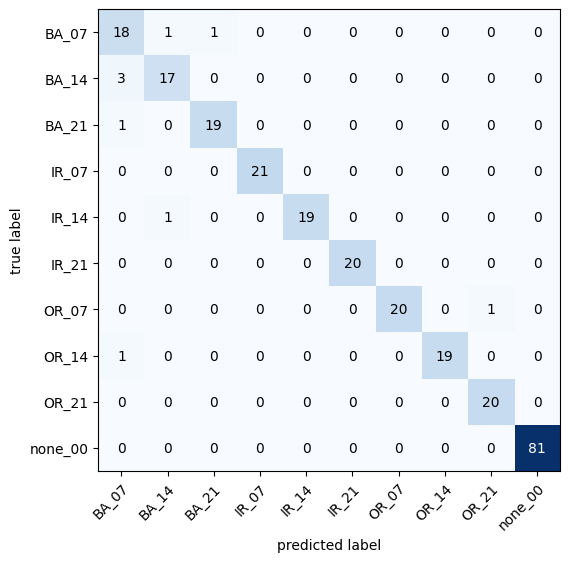

In [83]:
cm = confusion_matrix(y_true, y_pred)
fig = plot_confusion_matrix(cm, figsize=(6, 6), show_absolute=True, show_normed=False, class_names=predictor.class_labels)

### 7 Modell Interpretation <a class="anchor" id="3_7"></a>
In der folgenden Zelle wird die sog. Merkmalswichtigkeit (engl.: feature importance) berechnet und aufgelistet (1. Spalte). Je höher die Wichtigkeit (importance), umso bedeutender und gewichtiger ist der Einfluss des jeweiligen Merkmals zur Bestimmung einer Vorhersage. Dies kann sehr aufschlussreich sein, um zu verstehen welche Merkmale eher wichtig und welche eher unwichtig sind.

In [84]:
predictor.feature_importance(data_test, silent=True)

,importance,stddev,p_value,n,p99_high,p99_low
acc0_mean,0.290494,0.014873,8.216263e-07,5,0.321117,0.259871
acc1_min,0.098859,0.022655,3.089806e-04,5,0.145506,0.052213
acc0_min,0.070722,0.010273,5.195823e-05,5,0.091875,0.049570
acc1_max,0.058555,0.011279,1.573537e-04,5,0.081780,0.035331
acc0_max,0.051711,0.014628,6.927535e-04,5,0.081830,0.021592
acc1_mean,0.006084,0.006907,6.012167e-02,5,0.020306,-0.008138


### 8 Modell exportieren/speichern <a class="anchor" id="3_8"></a>
Um das trainierte Modell später wieder laden und benutzen zu können, muss es gespeichert werden. Dies geschieht schon automatisch beim Modell Training. Bei Bedarf kann man jedoch auch im Nachhinhein das Modell mittels der `save()` Methode speichern (optional unter Angabe eines Pfades der Wahl).

In [85]:
predictor.save()

TabularPredictor saved. To load, use: predictor = TabularPredictor.load("./results/Kugellager\")


### 9 Modell laden <a class="anchor" id="3_9"></a>
Um ein gespeichertes Modell zu laden, ruft man ganz einfach die `load()` Methode auf.

In [86]:
predictor = TabularPredictor.load(path="./results/Kugellager")

### 10 Vorhersagen für neue Daten <a class="anchor" id="3_10"></a>
Das geladene Modell kann nun genutzt werden, um Vorhersagen auf zukünftigen, komplett unbekannten Daten zu machen. Da wir über solche nicht verfügen, laden wir hier eine zufällige Instanz aus dem uns vorliegenden Datensatz und machen dafür eine Vorhersage mit unserem geladenen Modell.

In [87]:
test_window = data_features.sample()
test_window

,acc0_min,acc0_max,acc0_mean,acc1_min,acc1_max,acc1_mean,label
102,-1.320273,1.21469,0.002588,-0.354615,0.419127,0.037117,IR_14


In [89]:
prediction = predictor.predict(test_window.drop(columns=['label']))
print(f'Vorhergesagte Klasse: {", ".join(prediction.values)}')

Vorhergesagte Klasse: IR_14


## 3. Metallgussteile - Klassifikation mit Bilddaten <a class="anchor" id="4"></a>

Dieses Notebook ist ein einfaches Beispiel dafür, wie man ein Vorhersagemodell mittels AutoML anhand von Bilddaten trainiert.
Ziel ist es, eine automatische Qualitätskontrolle für Metallgussteile zu entwickeln.
Dabei unterscheiden wir nur zwischen defekten und nicht defekten Gussteilen.

### Inhaltsverzeichnis
1. [Imports](#4_1)<br/>
2. [Laden der Daten](#4_2)<br/>
3. [Modell Training](#4_3)<br/>
4. [Modell Test](#4_4)<br/>
5. [Modell exportieren/speichern](#4_5)<br/>
6. [Modell laden](#4_6)<br/>
7. [Vorhersagen für neue Daten](#4_7)<br/>
8. [Aufgaben](#4_8)

### 1 Imports <a class="anchor" id="4_1"></a>
In diesem Beispiel verwenden wir das AutoML-Framework AutoGluon. Da es sich bei dem Datensatz um Bilder handelt, benötigen wir für die Bearbeitung des vorliegenden Problems die Klassen `ImageDataset` und `ImagePredictor`, welche wir hier importieren.

In [91]:
from autogluon.multimodal import MultiModalPredictor

import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

### 2 Laden der Daten <a class="anchor" id="4_2"></a>

Der Datensatz enthält Bilder von Tauchpumpenlaufrädern aus Metallguss. Da während der Herstellung eine Vielzahl von Fehlern auftreten können, muss jedes Produkt einen Qualitätskontrollprozess durchlaufen. Diese (optische) Qualitätskontrolle kann durch maschinelles Lernen automatisiert werden, indem von jedem Erzeugnis ein Bild aufgenommen wird und dieses anschließend klassifiziert wird (Fehler oder kein Fehler).

<img src="./assets/Tauchpumpe mit Laufrad.jpg" alt="drawing" style="width:50%"/>

Weitere Informationen zum Datensatz sind unter foldendem Link zu finden: [https://www.kaggle.com/ravirajsinh45/real-life-industrial-dataset-of-casting-product](https://www.kaggle.com/ravirajsinh45/real-life-industrial-dataset-of-casting-product)

Über die Ordnerstruktur ist bereits festgelegt, welche der Bilder im Trainings- bzw. im Testset enthalten sind. In den jeweiligen Unterordnern "def_front" bzw. "ok_front" befinden sich die Bilder des entsprechenden Labels.

Wir laden die Daten mit Hilfe der `from_folders()` Methode der `ImageDataset` Klasse und speichern sie in den Variablen `train_data` und `test_Data`. Neben dem Ordnernamen müssen wir hierbei noch den Namen der jeweiligen Ordner mit den Trainings- bzw. Testdaten angeben. Mittels der `head()` Methode können wir uns die ersten 5 Instanzen des Trainingsdatensatzes anzeigen lassen.

In [93]:
data_train_path = './data/Metallgussteile/train'
data_test_path = './data/Metallgussteile/test'

def dataframe_from_path(data_path):
    if not isinstance(data_path, Path):
        data_path = Path(data_path)

    # Initialize an empty list to store the image and label data
    data = []

    # Iterate over each subfolder in the given path
    for label in data_path.iterdir():
        if label.is_dir():
            # Iterate over each file in the subfolder
            for image in label.iterdir():
                if image.is_file():
                    # Append the full path of the image and its label to the list
                    data.append([str(image), label.name])

    # Convert the list into a pandas DataFrame
    df = pd.DataFrame(data, columns=['image', 'label'])
    return df

data_train = dataframe_from_path(data_train_path)
data_test = dataframe_from_path(data_test_path)
print(f'Trainingsset: {len(data_train)} Bilder')
print(f'Testset: {len(data_test)} Bilder')
data_train.head()

Trainingsset: 6633 Bilder
Testset: 715 Bilder


,image,label
0,data\Metallgussteile\train\def_front\cast_def_0_0.jpeg,def_front
1,data\Metallgussteile\train\def_front\cast_def_0_1000.jpeg,def_front
2,data\Metallgussteile\train\def_front\cast_def_0_1001.jpeg,def_front
3,data\Metallgussteile\train\def_front\cast_def_0_1004.jpeg,def_front
4,data\Metallgussteile\train\def_front\cast_def_0_1007.jpeg,def_front


Um das Training etwas zu beschleunigen, reduzieren wir die Datenmenge auf 30%. Im Normalfall würde man davon absehen und die volle Datenmenge heranziehen, da somit auch ein besseres Modell zu erwarten ist. In diesem Beispiel Notebook wollen wir jedoch die Trainingszeit etwas auf Kosten der Genauigkeit reduzieren.

In [94]:
fraction = 0.3
data_train = data_train.sample(frac=fraction)
data_test = data_test.sample(frac=fraction)
print(f'Trainingsset:\t{len(data_train)} Bilder')
print(f'Testset:\t{len(data_test)} Bilder')

Trainingsset:	1990 Bilder
Testset:	214 Bilder


In der folgenden Zelle nutzen wir die `show_images()` Methode, um jeweils vier Bilder der beiden Klassen zu visualisieren.

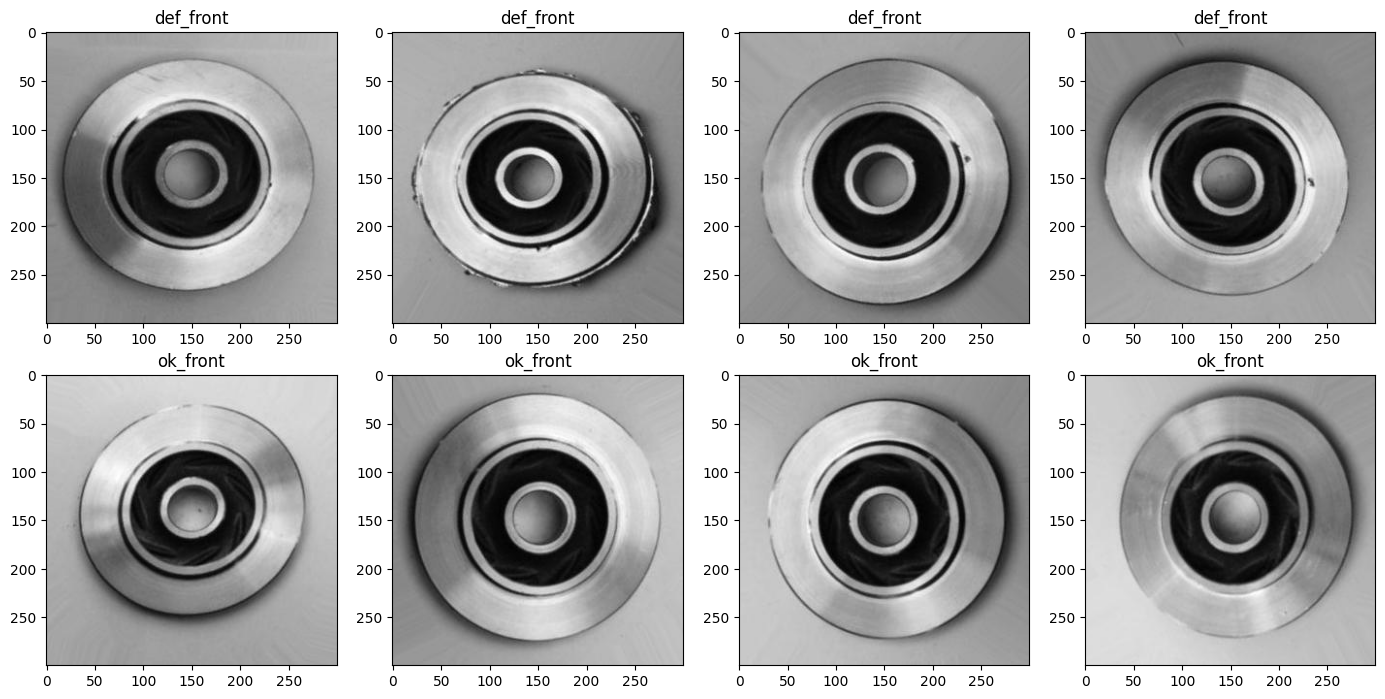

In [95]:
def display_images_grid(dataframe, n_samples=4):
  labels = dataframe['label'].unique()
  n_rows = len(labels)
  n_cols =  n_samples

  # Create a figure with the correct grid
  fig, axes = plt.subplots(n_rows, n_cols , figsize=(14,  7))

  for i, label in enumerate(labels):
    # Select  4 images for each label
    label_images = dataframe[dataframe['label'] == label]['image'].values[:n_samples]

    for j, img_path in enumerate(label_images):
      ax = axes[i, j]
      img = Image.open(img_path)
      ax.imshow(img)
      ax.set_title(label)

  # Adjust the layout and display the grid
  plt.tight_layout()
  plt.show()

display_images_grid(data_train)

### 3 Modell Training <a class="anchor" id="4_3"></a>
In der folgenden Zelle findet das Modell Training durch das AutoML Framework statt.

In der ersten Zeile erzeugen wir zuerst eine Instanz der Klasse `ImagePredictor` und speichern diese in der Variablen `predictor`.
Optional kann man den Pfad angeben, in dem das Modell später gespeichert werden sollen (hier: "AutogluonModels/Metallgussteile").
Gibt man keinen Pfad an, so wird automatisch ein Ordner "AutogluonModels/ag-\<Datum>_\<Uhrzeit>" erstellt, in dem das Modell später gespeichert wird.

In der zweiten Zeile rufen wir dann die `fit()` Methode auf, welche das Modell Training startet.
Diese Methode benötigt unsere vorher definierten Trainingsdaten als Argument.

Das AutoML Framework trainiert und validiert nun mit Hilfe dieser Daten ein Modell.

! HINWEIS: Je nach definierter Datenmenge sowie CPU/GPU kann der Trainingsprozess sehr lange dauern !

In [96]:
predictor = MultiModalPredictor(label='label')
predictor.fit(train_data=data_train, presets='medium_quality')

No path specified. Models will be saved in: "AutogluonModels\ag-20240223_124311\"
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  ['def_front', 'ok_front']
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
INFO:lightning_fabric.utilities.seed:Global seed set to 0
AutoMM starts to create your model. ✨

- AutoGluon version is 0.8.0.

- Pytorch version is 1.13.1+cpu.

- Model will be saved to "c:\Users\kasper\repos\github\KI-Tutorials\AutogluonModels\ag-20240223_124311".

- Validation metric is "roc_auc".

- To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir c:\Users\kasper\repos\github\KI-Tutorials\AutogluonModels\ag-20240223_124311
    ```

Enjoy your 

model.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

c:\Users\kasper\AppData\Local\miniconda3\envs\ki-tutorials\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kasper\.cache\huggingface\hub\models--timm--mobilenetv3_large_100.ra_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
0 GPUs are detected, and 0 GPUs will be used.

c:\Users\kasper\AppData

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 6: 'val_roc_auc' reached 0.87551 (best 0.87551), saving model to 'c:\\Users\\kasper\\repos\\github\\KI-Tutorials\\AutogluonModels\\ag-20240223_124311\\epoch=0-step=6.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 12: 'val_roc_auc' reached 0.98988 (best 0.98988), saving model to 'c:\\Users\\kasper\\repos\\github\\KI-Tutorials\\AutogluonModels\\ag-20240223_124311\\epoch=0-step=12.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 19: 'val_roc_auc' reached 0.99638 (best 0.99638), saving model to 'c:\\Users\\kasper\\repos\\github\\KI-Tutorials\\AutogluonModels\\ag-20240223_124311\\epoch=1-step=19.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 25: 'val_roc_auc' reached 0.99558 (best 0.99638), saving model to 'c:\\Users\\kasper\\repos\\github\\KI-Tutorials\\AutogluonModels\\ag-20240223_124311\\epoch=1-step=25.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 32: 'val_roc_auc' reached 0.99513 (best 0.99638), saving model to 'c:\\Users\\kasper\\repos\\github\\KI-Tutorials\\AutogluonModels\\ag-20240223_124311\\epoch=2-step=32.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 38: 'val_roc_auc' reached 0.99908 (best 0.99908), saving model to 'c:\\Users\\kasper\\repos\\github\\KI-Tutorials\\AutogluonModels\\ag-20240223_124311\\epoch=2-step=38.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 45: 'val_roc_auc' reached 0.99869 (best 0.99908), saving model to 'c:\\Users\\kasper\\repos\\github\\KI-Tutorials\\AutogluonModels\\ag-20240223_124311\\epoch=3-step=45.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 51: 'val_roc_auc' reached 0.99872 (best 0.99908), saving model to 'c:\\Users\\kasper\\repos\\github\\KI-Tutorials\\AutogluonModels\\ag-20240223_124311\\epoch=3-step=51.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 58: 'val_roc_auc' was not in top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 64: 'val_roc_auc' was not in top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 71: 'val_roc_auc' reached 0.99885 (best 0.99908), saving model to 'c:\\Users\\kasper\\repos\\github\\KI-Tutorials\\AutogluonModels\\ag-20240223_124311\\epoch=5-step=71.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 77: 'val_roc_auc' reached 0.99879 (best 0.99908), saving model to 'c:\\Users\\kasper\\repos\\github\\KI-Tutorials\\AutogluonModels\\ag-20240223_124311\\epoch=5-step=77.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 84: 'val_roc_auc' reached 0.99893 (best 0.99908), saving model to 'c:\\Users\\kasper\\repos\\github\\KI-Tutorials\\AutogluonModels\\ag-20240223_124311\\epoch=6-step=84.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 90: 'val_roc_auc' was not in top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 97: 'val_roc_auc' was not in top 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 103: 'val_roc_auc' reached 0.99889 (best 0.99908), saving model to 'c:\\Users\\kasper\\repos\\github\\KI-Tutorials\\AutogluonModels\\ag-20240223_124311\\epoch=7-step=103.ckpt' as top 3
Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

AutoMM has created your model 🎉🎉🎉

- To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("c:\Users\kasper\repos\github\KI-Tutorials\AutogluonModels\ag-20240223_124311")
    ```

- You can open a terminal and launch Tensorboard to visualize the training log:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir c:\Users\kasper\repos\github\KI-Tutorials\AutogluonModels\ag-20240223_124311
    ```

- If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub: https://github.com/autogluon/autogluon




### 4 Modell Test <a class="anchor" id="4_4"></a>
Zum Testen und Evaluieren des finalen Modells verwenden wir die vorab separierten Testdaten.
Mit der `evaluate()` Methode können wir die Qualitätsmaße berechnen.

In [97]:
pred_metrics = predictor.evaluate(data_test)

Predicting: 0it [00:00, ?it/s]

Nun wollen wir uns etwas detailliertere Ergebnisse anschauen.

Dazu benutzen wir zunächst die `predict()` Methode, um unsere Vorhersagen für den Testdatensatz zu machen. Die Vorhersagen speichern wir in der Variable `y_pred`. Die tatsächlichen Label speichern wir in der Variable `y_true`.

In [98]:
y_pred = predictor.predict(data_test)
y_true = data_test['label']

Predicting: 0it [00:00, ?it/s]

Mit Hilfe von `y_pred` und `y_true` können wir uns nun einen Klassifikations-Report ausgeben lassen. Dieser beinhaltet nicht nur die globale Genauigkeit (accuracy), sondern zeigt auch jeweils die Relevanz (precision), die Sensitivität (recall) sowie den F1-Score für die beiden Klassen im Datensatz an. Die support Spalte gibt an, wie viele Instanzen der jeweiligen Klasse sich im Testdatensatz befinden. 

In [99]:
print(classification_report(y_pred=y_pred, y_true=y_true))

              precision    recall  f1-score   support

   def_front       1.00      1.00      1.00       136
    ok_front       1.00      1.00      1.00        78

    accuracy                           1.00       214
   macro avg       1.00      1.00      1.00       214
weighted avg       1.00      1.00      1.00       214



Eine zusätzliche Möglichkeit, die Ergebnisse detailliert zu visualisieren bietet die sog. Konfusionsmatrix.
Entlang der x-Achse sehen wir die vom Modell gemachten Vorhersagen, auf der y-Achse die tatsächlichen Label.

Im Feld links oben (1. Zeile, 1. Spalte) steht also die Anzahl der Instanzen in den Traingsdaten, bei denen tatsächlich ein Defekt vorlag und dies von unserem Modell auch so vorhergesagt wurde.

Im Feld darunter (2. Zeile, 1. Spalte) steht die Anzahl der Instanzen, bei denen tatsächlich kein Defekt vorlag, unser Modell aber fälschlicherweise einen Defekt vorhergesagt hat, usw.

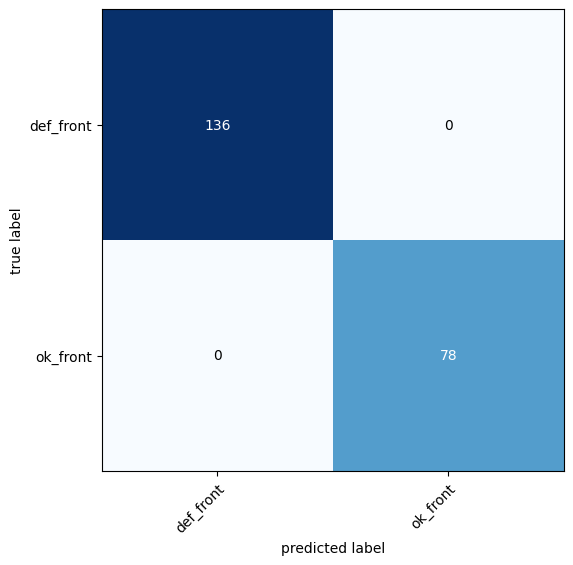

In [100]:
cm = confusion_matrix(y_true, y_pred)
fig = plot_confusion_matrix(cm, figsize=(6, 6), show_absolute=True, show_normed=False, class_names=data_test.label.unique())

### 5 Modell exportieren/speichern <a class="anchor" id="4_5"></a>
Um das trainierte Modell später wieder laden und benutzen zu können, muss es zunächst gespeichert werden. Dies geschieht mittels der `save()` Methode.

In [101]:
predictor.save(path='./output/predictor/')

### 6 Modell laden <a class="anchor" id="4_6"></a>
Um ein gespeichertes Modell zu laden, ruft man ganz einfach die `load()` Methode unter Angabe des gewünschten Pfades auf.

In [102]:
predictor = MultiModalPredictor.load(path='./output/predictor/')

Load pretrained checkpoint: c:\Users\kasper\repos\github\KI-Tutorials\output\predictor\model.ckpt


### 7 Vorhersagen für neue Daten <a class="anchor" id="4_7"></a>
Das geladene Modell kann nun genutzt werden, um Vorhersagen auf zukünftigen, komplett unbekannten Daten zu machen. Da wir über solche nicht verfügen, laden wir hier eine zufällige Instanz aus dem uns vorliegenden Datensatz und machen dafür eine Vorhersage mit unserem geladenen Modell.

,image,label
83,data\Metallgussteile\test\def_front\cast_def_0_1506.jpeg,def_front


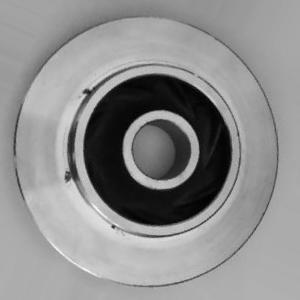

In [103]:
test_img = data_test.sample() # eine zufällige Instanz wird aus dem Datensatz gezogen
display(test_img)
Image.open(test_img.image.item())

In [104]:
prediction = predictor.predict(test_img)
print(f'Vorhergesagte Klasse: {prediction.values[0]} (Tatsächliche Klasse: {test_img.label.item()})')

Vorhergesagte Klasse: def_front (Tatsächliche Klasse: def_front)
